In [100]:
import pandas as pd
import numpy as np

import gensim
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,  roc_curve, auc, RocCurveDisplay
from cycler import cycler


from keras import utils, regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Dropout, Bidirectional
from keras.models import Sequential


import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('data/cleaned_tweets.csv')
df['category'] = df['category'].replace('not_disaster', 'neutral') 
df.drop('label', axis = 1, inplace = True)
display(df.shape)
df.head()

(64122, 2)

,tweet,category
0,jay1972jay nope mid 80 it off metallica 2nd...,neutral
1,nothing like a :16 second downpour to give us ...,neutral
2,nelsontagoona so glad that you missed the floo...,floods
3,party hard suns down still warm lovin life smi...,neutral
4,exclusionzone if you compare yourself to water...,neutral


In [3]:
df.category.value_counts()

neutral       27493
floods         9022
earthquake     8745
hurricane      5579
bombing        4879
explosion      4236
tornado        4168
Name: category, dtype: int64

In [4]:
# Using an additional data set with other categories of disasters to expand our predictions classes. 
additional = pd.read_csv('data/clean_df.csv')
df2 = pd.DataFrame(columns = ['text', 'type'], data = additional)

df2.rename(columns = {'text':'tweet', 'type': 'category'}, inplace = True)
df2
df2['category'] = df2['category'].replace('flood', 'floods') 
df = pd.concat([df, df2], ignore_index=True, axis = 0)


display(df.category.value_counts(normalize=True))

neutral       0.316070
hurricane     0.199255
floods        0.135347
earthquake    0.100536
tornado       0.079681
bombing       0.056091
explosion     0.048699
noreaster     0.033615
mudslide      0.030707
Name: category, dtype: float64

In [18]:
#To further round out our training data, importing additional tweets involving wildfires 
df3 = pd.read_csv('https://raw.githubusercontent.com/Dong-UTIL/Natural-Hazards-Twitter-Dataset/master/2018Wildfires_Summary.csv')
df3 = pd.DataFrame(columns = ['text', 'label'], data = df3)
df3.rename(columns = {'text':'tweet', 'label': 'category'}, inplace = True)
df3['category'] = df3['category'].replace({1: 'wildfire', 0 : 'neutral'}) 
df = pd.concat([df, df3], ignore_index=True, axis = 0)

df.head()

df.to_csv('data/combined_cleaned_tweets_for_training.csv')

In [6]:
df.category.value_counts(normalize=True)

neutral       0.303844
hurricane     0.189255
floods        0.128554
earthquake    0.095490
tornado       0.075682
bombing       0.053276
wildfire      0.046549
explosion     0.046255
noreaster     0.031928
mudslide      0.029166
Name: category, dtype: float64

In [7]:
#Processing the text data, including tokenizing, lemmentizing and padding.
#This entire function will
def process_tweet():
    tokenizer = RegexpTokenizer('\w+|\$[\d\.]\S+')
    lem = WordNetLemmatizer()
    STOPWORDS = set(stopwords.words('english'))
    df['processed_tweets'] = df['tweet'].apply(tokenizer.tokenize)
    df['processed_tweets'] = df['processed_tweets'].apply(lambda row: list([lem.lemmatize(i) for i in row]))
    df['processed_tweets'] = df['processed_tweets'].apply(lambda x:[i for i in x if i not in STOPWORDS] )
    
    tokenizer = Tokenizer(num_words= 5000)
    tokenizer.fit_on_texts(df.processed_tweets.tolist())
    X = tokenizer.texts_to_sequences(df.processed_tweets.tolist())
    X = pad_sequences(X, maxlen = df.processed_tweets.str.len().max(), padding = 'post')
    return X

X = process_tweet()

In [8]:
#Establishing and enoding our y variable.
y = df['category']
le = LabelEncoder()
y = le.fit_transform(y)
y = utils.to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [9]:
#Importing our pre-trained Word2Vec model

t0 = time.time()

w2v = gensim.models.KeyedVectors.load_word2vec_format(
    '/Users/mathea/Downloads/lexvec.commoncrawl.300d.W.pos.neg3.vectors')

print(time.time() - t0)

512.9523613452911


In [13]:
#Establishing our Word2Vec embedding layer, it's dimensions and pre-trained weights. 
embedding_layer = Embedding(input_dim = w2v.wv.vectors.shape[0],
                           output_dim = w2v.wv.vectors.shape[1],
                           weights = [w2v.wv.vectors])

<ipython-input-13-9eacca66d170>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  embedding_layer = Embedding(input_dim = w2v.wv.vectors.shape[0],
<ipython-input-13-9eacca66d170>:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  output_dim = w2v.wv.vectors.shape[1],
<ipython-input-13-9eacca66d170>:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  weights = [w2v.wv.vectors])


In [15]:
#Model architecture 

model = Sequential()

model.add(embedding_layer)
model.add(Bidirectional(LSTM(128, activation = 'relu', kernel_regularizer = regularizers.l2(0.01))))
model.add(Dropout(0.3))
model.add(Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(10, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])



In [16]:
#Training our RNN model

#history = model.fit(X_train, y_train, validation_data = (X_test, y_test),
#          batch_size = 512, epochs = 10)

Epoch 1/10
144/144 [==============================] - 1401s 10s/step - loss: 57.5922 - acc: 0.2886 - val_loss: 1.6971 - val_acc: 0.6362
Epoch 2/10
144/144 [==============================] - 1370s 10s/step - loss: 1.5001 - acc: 0.7350 - val_loss: 1.0109 - val_acc: 0.8655
Epoch 3/10
144/144 [==============================] - 1334s 9s/step - loss: 0.9081 - acc: 0.8917 - val_loss: 0.7688 - val_acc: 0.9075
Epoch 4/10
144/144 [==============================] - 1372s 10s/step - loss: 0.7269 - acc: 0.9165 - val_loss: 0.6916 - val_acc: 0.9119
Epoch 5/10
144/144 [==============================] - 1382s 10s/step - loss: 0.6337 - acc: 0.9263 - val_loss: 0.6554 - val_acc: 0.9164
Epoch 6/10
144/144 [==============================] - 1386s 10s/step - loss: 0.5840 - acc: 0.9293 - val_loss: 0.6349 - val_acc: 0.9153
Epoch 7/10
144/144 [==============================] - 1391s 10s/step - loss: 0.5573 - acc: 0.9326 - val_loss: 0.6198 - val_acc: 0.9158
Epoch 8/10
144/144 [==============================] - 1

In [17]:
#Saving our LSTM model for use in our ongoing predictions and flagging system. 
model_saved = model.save('Word2Vec_LSTM_model.h5')

In [75]:
predictions = np.argmax(model.predict(X_test), axis=-1)
predictions = utils.to_categorical(predictions)

In [77]:
#Using the ROC AUC score to evaluate our model
roc_auc_score(y_test, predictions, multi_class='ovr')

0.9478796144619267

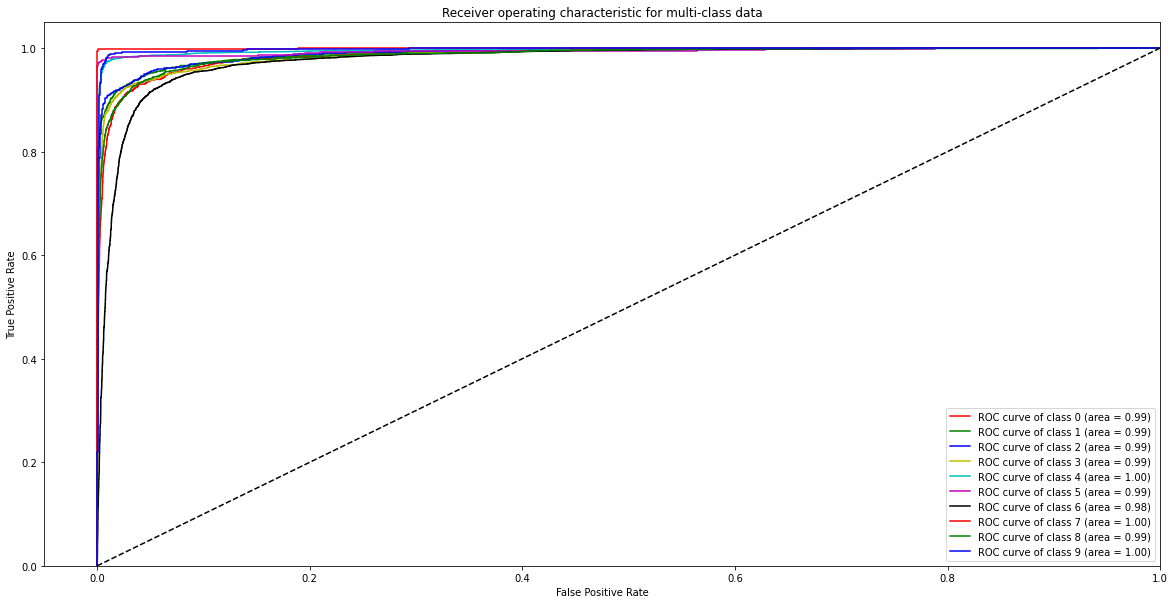

In [125]:
#Plotting the one vs rest auc score for each category.

n_classes = y.shape[1]
y_score = model.predict(X_test)

plt.figure(figsize = (20, 10))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = ['r', 'g', 'b', 'y', 'c', 'm', 'k', 'r', 'g', 'b']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Keyword Extraction

Because our pre-trained Word2Vec model is so comprehensive, we will use similar words to our disaster categories to scrape Twitter for relevant tweets. The below function produces a list of keywords which will be used in the ongoing Twitter scraping notebook. 

In [27]:
similar_words = []

for i in df.category.unique()[1:-1]: #Taking out neutral category from the keyword search 
    x = w2v.most_similar(i, topn=15)
    for word in range(len(x)):
        similar_words.append(x[word][0])
    
similar_words

/Users/mathea/opt/anaconda3/lib/python3.8/site-packages/gensim/models/keyedvectors.py:2389: RuntimeWarning: invalid value encountered in true_divide
  return (m / dist).astype(REAL)


['flooding',
 'mudslides',
 'droughts',
 'landslides',
 'flood',
 'storms',
 'wildfires',
 'earthquakes',
 'tornadoes',
 'floodwaters',
 'typhoons',
 'disasters',
 'tsunami',
 'tsunamis',
 'earthquake',
 'explosions',
 'exploded',
 'explodes',
 'blast',
 'exploding',
 'explode',
 'bomb',
 'detonation',
 'implosion',
 'earthquake',
 'detonations',
 'catastrophe',
 'burst',
 'fires',
 'blasts',
 'quake',
 'tsunami',
 'earthquakes',
 'aftershocks',
 'quakes',
 'floods',
 'temblor',
 'disaster',
 'devastation',
 'tsunamis',
 'landslides',
 'disasters',
 'magnitude',
 'mudslides',
 'flood',
 'hurrican',
 'storm',
 'hurricanes',
 'katrina',
 'storms',
 'tornado',
 'cyclone',
 'tsunami',
 'typhoon',
 'disaster',
 'landfall',
 'earthquake',
 'flood',
 'huricane',
 'tornadoes',
 'tornadoes',
 'tornados',
 'storm',
 'thunderstorm',
 'hurricane',
 'tsunami',
 'cyclone',
 'storms',
 'typhoon',
 'floods',
 'snowstorm',
 'tornadic',
 'flood',
 'earthquake',
 'waterspout',
 'bombings',
 'bombed',
 'b